In [1]:
# 用pagerank挖掘希拉里邮件中的重要关系
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx

### 数据

In [2]:
emails = pd.read_csv('./data/PageRank-master/input/Emails.csv')
emails

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7940,7941,C05778462,WYDEN,H,"Verma, Richard R",180.0,2010-12-16T05:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0113/DOC_0C0...,F-2014-20439,...,NaN,"Verma, Richard R <VermaRR@state.gov>",NaN,"Thursday, December 16, 2010 7:41 PM",F-2014-20439,C05778462,08/31/2015,RELEASE IN PART,NaN,UNCLASSIFIED U.S. Department of State Case No....
7941,7942,C05778463,SENATE,H,"Verma, Richard R",180.0,2010-12-16T05:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0113/DOC_0C0...,F-2014-20439,...,NaN,"Verma, Richard R <VermaRR@state.gov>","Sullivan, Jacob J; Mills, Cheryl D; Abedin, Huma","Thursday, December 16, 2010 8:09 PM",F-2014-20439,C05778463,08/31/2015,RELEASE IN FULL,Big change of plans in the Senate. Senator Rei...,UNCLASSIFIED U.S. Department of State Case No....
7942,7943,C05778465,RICHARD (TNR),H,"Jiloty, Lauren C",116.0,2010-12-16T05:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0113/DOC_0C0...,F-2014-20439,...,NaN,"Jiloty, Lauren C <JilotyLC@state.gov>",NaN,"Thursday, December 16, 2010 10:52 PM",F-2014-20439,C05778465,08/31/2015,RELEASE IN PART,NaN,UNCLASSIFIED U.S. Department of State Case No....
7943,7944,C05778466,FROM,H,PVerveer,143.0,2012-12-17T05:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0113/DOC_0C0...,F-2014-20439,...,"PVervee,",NaN,NaN,12/14/201,F-2014-20439,C05778466,08/31/2015,RELEASE IN PART,"PVerveer B6\nFriday, December 17, 2010 12:12 A...","Hi dear Melanne and Alyse,\nHope this email re..."


In [3]:
# 读取别名文件
file = pd.read_csv('./data/PageRank-master/input/Aliases.csv')
file

,Id,Alias,PersonId
0,1,111th congress,1
1,2,agna usemb kabul afghanistan,2
2,3,ap,3
3,4,asuncion,4
4,5,alec,5
...,...,...,...
845,846,marshallcp@state.goy,509
846,847,sid blumenthal,510
847,848,monica.hanle,511
848,849,hanle mr@state.gov,512


In [7]:
aliases = dict(zip(file['Alias'],file['PersonId']))
aliases

{'111th congress': 1,
 'agna usemb kabul afghanistan': 2,
 'ap': 3,
 'asuncion': 4,
 'alec': 5,
 'dupuy alex': 6,
 'american beverage association': 7,
 'mayock andrew': 8,
 'shapiro andrew j': 9,
 'shapiroa@state.gov': 9,
 'slaughter annmarie': 10,
 'slaughter anne marie': 10,
 'slaughter annemarie': 10,
 'slaughtera@state.gov': 10,
 'lake anthony': 11,
 'valenzuela arturo a': 12,
 'valenzuelaaa@state.gov': 12,
 'kimoon ban': 13,
 'obama barack': 14,
 'president': 14,
 'bam@mikulski.senate.gov': 15,
 'mikulski bam': 15,
 'mikulski bam (mikulski)': 15,
 'mikulski bam (mitkulski)': 15,
 'mikulskibam (mikulski)': 15,
 'betsy.ebeling': 16,
 'ebeling betsy': 16,
 'betsyebeling': 16,
 'betsyebeling1050': 16,
 'clinton william j': 17,
 'dad': 17,
 'biography': 18,
 'klehr bonnie': 19,
 'brian': 20,
 'bstrider': 21,
 'strider burns': 21,
 'capricia marshall': 22,
 'marshall capricia': 22,
 'marshall capricia p': 22,
 'capriciamarshall': 22,
 'capriciamarshall@': 22,
 'cmarshall': 22,
 'marshal

In [8]:
# 读取人名文件
file2 = pd.read_csv('./data/PageRank-master/input/Persons.csv')
file2

,Id,Name
0,1,111th Congress
1,2,AGNA USEMB Kabul Afghanistan
2,3,AP
3,4,ASUNCION
4,5,Alec
...,...,...
508,509,marshallcp@state.goy
509,510,sid blumenthal
510,511,monica.hanle
511,512,hanle mr@state.gov


In [9]:
persons=dict(zip(file2['Id'],file2['Name']))
persons

{1: '111th Congress',
 2: 'AGNA USEMB Kabul Afghanistan',
 3: 'AP',
 4: 'ASUNCION',
 5: 'Alec',
 6: 'Alex Dupuy',
 7: 'American Beverage Association',
 8: 'Andrew Mayock',
 9: 'Andrew Shapiro',
 10: 'Anne-Marie Slaughter',
 11: 'Anthony Lake',
 12: 'Arturo Valenzuela',
 13: 'Ban Ki-moon',
 14: 'Barack Obama',
 15: 'Barbara Mikulski',
 16: 'Betsy Ebeling',
 17: 'Bill Clinton',
 18: 'Biography',
 19: 'Bonnie Klehr',
 20: 'Brian Greenspun',
 21: 'Burns Strider',
 22: 'Capricia Marshall',
 23: 'Carlos Pascual',
 24: 'Caroline Adler',
 25: 'Case Button',
 26: 'Cecile Richards',
 27: 'Chad Weston',
 28: 'Charles Kiamie',
 29: 'Chelsea Clinton',
 30: 'Cherie Blair',
 31: 'Cheryl',
 32: 'Cheryl Mills',
 33: 'Chester Crocker',
 34: 'Christopher Butzgy',
 35: 'Christopher Edwards',
 36: 'Christopher Green',
 37: 'Christopher Hill',
 38: 'Claire Coleman',
 39: 'Colin Powell',
 40: 'Council on Foreign Relations',
 41: 'Courtney Beale',
 42: 'Craig Kelly',
 43: 'Daily Sun',
 44: 'Dana Hyde',
 45: '

In [10]:
# 针对别名进行转换        
def unify_name(name):
    # 姓名统一小写
    name = str(name).lower()
    # 去掉, 和@后面的内容
    name = name.replace(",","").split("@")[0]
    # 别名转换
    if name in aliases.keys():
        return persons[aliases[name]]
    return name

In [11]:
# 画网络图
def show_graph(graph):
    # 使用Spring Layout布局，类似中心放射状
    positions=nx.spring_layout(graph)
    # 设置网络图中的节点大小，大小与pagerank值相关，因为pagerank值很小所以需要*20000
    nodesize = [x['pagerank']*20000 for v,x in graph.nodes(data=True)]
    # 设置网络图中的边长度
    edgesize = [np.sqrt(e[2]['weight']) for e in graph.edges(data=True)]
    # 绘制节点
    nx.draw_networkx_nodes(graph, positions, node_size=nodesize, alpha=0.4)
    # 绘制边
    nx.draw_networkx_edges(graph, positions, edge_size=edgesize, alpha=0.2)
    # 绘制节点的label
    nx.draw_networkx_labels(graph, positions, font_size=10)
    # 输出希拉里邮件中的所有人物关系图
    plt.show()

In [13]:
emails.columns

Index(['Id', 'DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')

In [14]:
emails.MetadataFrom

0         Jake Sullivan
1                   nan
2          Cheryl Mills
3          Cheryl Mills
4       Hillary Clinton
             ...       
7940      Richard Verma
7941      Richard Verma
7942      Lauren Jiloty
7943    Melanne Verveer
7944      Jake Sullivan
Name: MetadataFrom, Length: 7945, dtype: object

In [12]:
# 将寄件人和收件人的姓名进行规范化
emails.MetadataFrom = emails.MetadataFrom.apply(unify_name)
emails.MetadataTo = emails.MetadataTo.apply(unify_name)

In [15]:
emails.MetadataFrom

0         Jake Sullivan
1                   nan
2          Cheryl Mills
3          Cheryl Mills
4       Hillary Clinton
             ...       
7940      Richard Verma
7941      Richard Verma
7942      Lauren Jiloty
7943    Melanne Verveer
7944      Jake Sullivan
Name: MetadataFrom, Length: 7945, dtype: object

In [16]:
# 设置遍的权重等于发邮件的次数
edges_weights_temp = defaultdict(list)
for row in zip(emails.MetadataFrom, emails.MetadataTo, emails.RawText):
    temp = (row[0], row[1])
    if temp not in edges_weights_temp:
        edges_weights_temp[temp] = 1
    else:
        edges_weights_temp[temp] = edges_weights_temp[temp] + 1

# 转化格式 (from, to), weight => from, to, weight
edges_weights = [(key[0], key[1], val) for key, val in edges_weights_temp.items()]

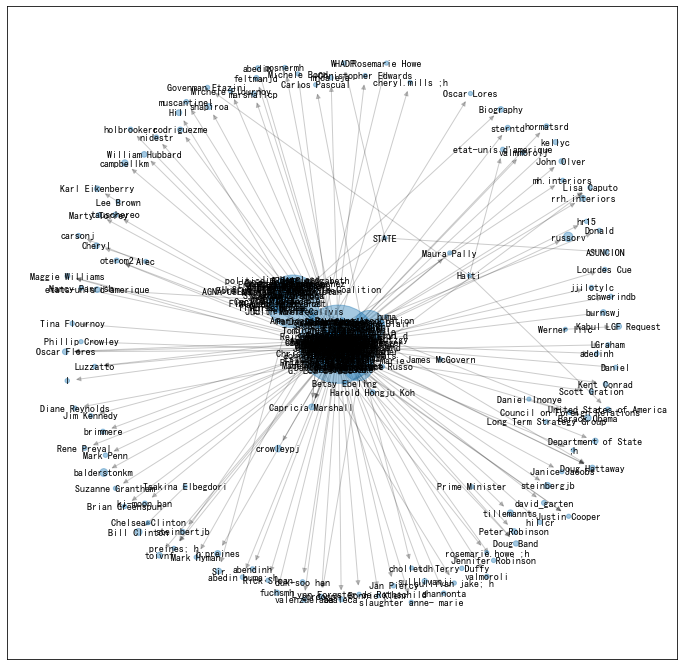

In [19]:
# 创建一个有向图
graph = nx.DiGraph()
# 设置有向图中的路径及权重(from, to, weight)
graph.add_weighted_edges_from(edges_weights)
# 计算每个节点（人）的PR值，并作为节点的pagerank属性
pagerank = nx.pagerank(graph)
# 获取每个节点的pagerank数值
pagerank_list = {node: rank for node, rank in pagerank.items()}
# 将pagerank数值作为节点的属性
nx.set_node_attributes(graph, name = 'pagerank', values=pagerank_list)
# 画网络图
plt.figure(figsize=(12,12))
show_graph(graph)

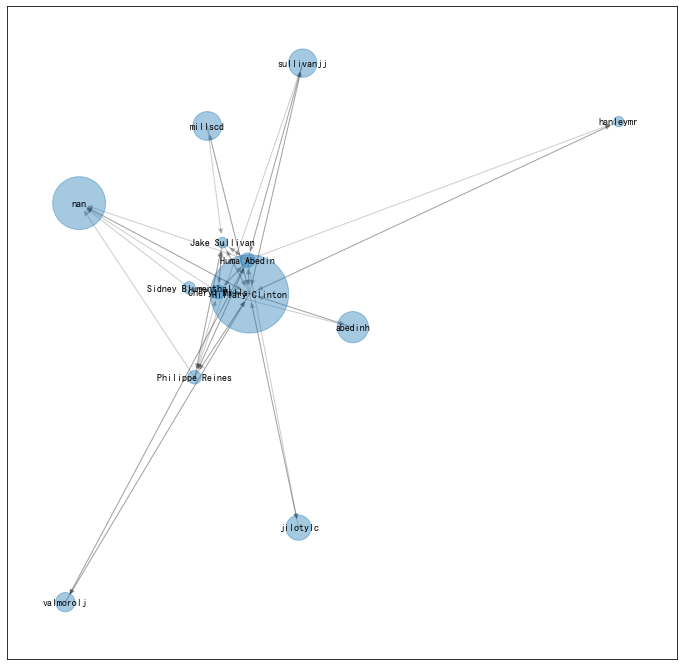

In [21]:
# 将完整的图谱进行精简
# 设置PR值的阈值，筛选大于阈值的重要核心节点
pagerank_threshold = 0.005
# 复制一份计算好的网络图
small_graph = graph.copy()
# 剪掉PR值小于pagerank_threshold的节点
for n, p_rank in graph.nodes(data=True):
    if p_rank['pagerank'] < pagerank_threshold: 
        small_graph.remove_node(n)
# 画网络图
plt.figure(figsize=(12,12))
show_graph(small_graph) 